<a href="https://colab.research.google.com/github/lucinex/VoltaML_Assignment/blob/main/VIT_BERT_Flicker8K_Edit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Remarks: EDIT 2, we used trainer provided by hugging face.
1. Shall consider reducing encoder and decoder sizes. 
2. Run Longer epochs 
3. Imporove sentence bleu 

[![Open in Colab] (https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.github.com/lucinex/VoltaML_Assignment/VIT_BERT-Flicker8K.ipynb)

In [1]:
!pip install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.4 MB/s 
     |████████████████████████████████| 7.6 MB 61.8 MB/s 
     |████████████████████████████████| 182 kB 80.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 4.6 MB/s 
     |████████████████████████████████| 452 kB 40.2 MB/s 
     |████████████████████████████████| 132 kB 62.7 MB/s 
     |████████████████████████████████| 212 kB 29.7 MB/s 
     |████████████████████████████████| 127 kB 21.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!nvidia-smi

Fri Dec 23 04:56:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import time
import sys 
import os 

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from PIL import Image
import PIL
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, ViTConfig, VisionEncoderDecoderConfig, ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel
# from torchtext.data.metrics import bleu_score
import random
import matplotlib.pyplot as plt
import matplotlib
from transformers import TrainingArguments, Trainer
import evaluate

%matplotlib inline
random.seed(32)


def mk_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)
    print("Created new Directory {}".format(path))
  else:
    print("Directory {} already exists".format(path))

In [ ]:
print("pandas == "+str(pd.__version__))
print("numpy == "+str(np.__version__))

print("pillow == "+str(PIL.__version__))
print("transformers == "+str(transformers.__version__))
print("torch == "+str(torch.__version__))
print("nltk == "+str(nltk.__version__))
print("evaluate == "+str(evaluate.__version__))
print("matplotlib == "+str(matplotlib.__version__))

pandas == 1.3.5
numpy == 1.21.6
pillow == 7.1.2
transformers == 4.25.1
torch == 1.13.0+cu116
nltk == 3.7
evaluate == 0.4.0
matplotlib == 3.2.2


In [4]:
# run this cell to specify location and create directories 
# specify Root folder 



ROOT_PATH = "/content"  # root folder, should be same as location of this notebook 
CAPTIONS_PATH = ROOT_PATH+"/"+"FLICKER8K_CAPTIONS"
IMAGES_PATH = ROOT_PATH+"/"+"FLICKER8K_IMAGES"
mk_dir(CAPTIONS_PATH)
mk_dir(IMAGES_PATH)



Created new Directory /content/FLICKER8K_CAPTIONS
Created new Directory /content/FLICKER8K_IMAGES


Step 2: Download the datasets. They will be automatically stored in the specified directories created in step 1. 

In [5]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip /content/Flickr8k_text.zip -d $CAPTIONS_PATH


!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip /content/Flickr8k_Dataset.zip -d $IMAGES_PATH

Streaming output truncated to the last 5000 lines.
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: /content/FLICKER8K_IMAGES/Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: /content/FLICKER8K_IMAGES/__MACO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# And some more path variabes. 

captions_path = CAPTIONS_PATH+"/Flickr8k.token.txt"
train_labels = CAPTIONS_PATH+ "/Flickr_8k.trainImages.txt"
dev_labels = CAPTIONS_PATH+ "/Flickr_8k.devImages.txt"
test_labels = CAPTIONS_PATH+"/Flickr_8k.testImages.txt"
image_dir = IMAGES_PATH+"/Flicker8k_Dataset"
DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Image Captioning"

The train, dev, test split is specified in different directories. The format of the dataset is strictly followed and any other representation of the same data might not be loaded properly. 

Run this cell ! 

In [72]:
def get_filenames(path):  # generator object
  try:
    data = []
    fp = open(path,'r').readlines()
    cont = [i.split("\n")[0] for i in fp]

  except Exception as e:
    print(e)
    cont = []
    return None
  finally:
    for i in cont:
      yield i

def distribution_dataframe(train_txt,dev_txt,test_txt):
  train_files = [[i,"train"] for i in get_filenames(train_txt)]
  dev_files = [[i,"dev"] for i in get_filenames(dev_txt)]
  test_files = [[i,"test"] for i in get_filenames(test_txt)]
  all_files = train_files + dev_files + test_files
  cols = ["Filename","dist"]
  df = pd.DataFrame(all_files,columns=cols)
  return df

def get_flicker8k_dataframe(caption_path: str ):
    # get the caption
  data = []
  cols = ['Filename','Caption']

  with open(caption_path,'r') as fp:
    lines = fp.readlines()
  
    for line in lines:
      fs = line.split()
      img_file = fs[0].split("#")[0]
      caption = " ".join(fs[1:])
      data.append([img_file, caption])
  caption_df = pd.DataFrame(data,columns=cols)
  return caption_df

def get_max_sentence_length(d):
  max_len = 0
  

def preprocess_captions(field):
  stopwords = """.,?/'"]}{{+=-_)(*&#@!`~"""
  field = [ i for i in field.split(" ") if not i in stopwords]   # remove punctuations and other stopwords
  field = [i.lower() for i in field]                             # lower case

  field = " ".join(field)
  return field

class Flicker_Dataset(Dataset):
  MAX_LENGTH=40

  def __init__(self,cap_df,image_dir,image_preprocess=None,tokenizer=None):
    self.cap_df = cap_df

    self.image_path = image_dir
    self.image_preprocess = image_preprocess
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.cap_df)
    
  def __getitem__(self, index):
 
    img_file = self.cap_df.iloc[index]
    
    image_path = self.get_image_path(img_file)
    image = Image.open(image_path)
    image = self.image_preprocess(image,return_tensors="pt").pixel_values
    
    # cap_files = self.cap_df.get_group(img_file)
    # rand_indx = random.randrange(start=0,stop=len(cap_files))
    cap = self.cap_df["Caption"].iloc[index]
   
    tokens = self.tokenizer(cap,add_special_tokens=True,return_tensors="pt",
                       padding="max_length",max_length=self.MAX_LENGTH).input_ids
   
    return {"pixel_values":torch.squeeze(image),"labels":torch.squeeze(tokens)}
        
  def get_image_path(self,path:str):
    return self.image_path+"/"+path


class BleuEvaluator(Flicker_Dataset):
  
  def __init__(self,cap_df,image_dir,image_preprocess=None,tokenizer=None):
    super().__init__(cap_df,image_dir,image_preprocess,tokenizer)
    self.filename_group_df = cap_df.groupby("Filename")
  def __getitem__(self, index):
 
    img_file = self.cap_df["Filename"].iloc[index]
    
    image_path = self.get_image_path(img_file)
    PILimage = Image.open(image_path)
    image = self.image_preprocess(PILimage,return_tensors="pt").pixel_values
    all_caps  = self.filename_group_df.get_group(img_file)["Caption"].values


    tokens = [ torch.squeeze(self.tokenizer(cap,add_special_tokens=True,return_tensors="pt").input_ids) for cap in all_caps]
   
    return dict({"PIL_Image":PILimage,"pixels":torch.squeeze(image),"captions":all_caps,"tokens":tokens})



class FlickerDataHandler:
  # This class handles the data according to the given structure of the directory present after cloning 

  def __init__(self,image_dir,caption_path:str, label_paths:dict(),
               image_processor=None, tokenizer=None):
    self.label_dist = label_paths
    self.caption_path =  caption_path
    self.image_processor = image_processor if image_processor is not None else ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
    self.tokenizer = tokenizer  if tokenizer is not None else BertTokenizer.from_pretrained("bert-base-uncased")
    self.image_dir = image_dir
    self.caption_df = self.preprocess(**self.get_caption_dataframe())

  

    pass
  
  def get_all_cap_data(self,dist="train"):
    if dist == "all":
      return BleuEvaluator(self.caption_df.copy(),self.image_dir,self.image_processor,self.tokenizer)
    else:
      df = self.caption_df.groupby("dist").get_group(dist)
      
      return BleuEvaluator(df,self.image_dir,self.image_processor,self.tokenizer)
  
  def get_dataset(self,dist="train"):
    
    if dist == "all":
      return Flicker_Dataset(self.caption_df.copy(),self.image_dir,self.image_processor,self.tokenizer)
    else:
      df = self.caption_df.groupby("dist").get_group(dist)
      
      return Flicker_Dataset(df,self.image_dir,self.image_processor,self.tokenizer)
      
    
  def get_dataloader(self,dist="train",batch_size=16, shuffle=False,  num_workers=2, collate_fn=None,
           pin_memory=True, prefetch_factor=2, persistent_workers=True):
     df = self.get_dataset(dist)
     dataloader = DataLoader(df , batch_size=batch_size, shuffle=shuffle,  
                             num_workers=num_workers, collate_fn=collate_fn,
                              pin_memory=pin_memory, prefetch_factor=prefetch_factor,
                              persistent_workers=persistent_workers)
     return dataloader 
  def get_caption_dataframe(self):
    caption_df = get_flicker8k_dataframe(self.caption_path)
    dist_df = distribution_dataframe(self.label_dist["train"], self.label_dist["dev"], self.label_dist["test"])

    # all_data = pd.merge(caption_df,dist_df,how="inner",on="Filename")
    
    return {"caption":caption_df, "dist":dist_df}
  
  def preprocess(self, caption, dist):

    caption["Caption"] = caption["Caption"].apply(preprocess_captions) 
    dataframe = pd.merge(caption,dist,how="inner",on="Filename")
    return dataframe
  

# Data_handler = FlickerDataHandler("/content/FLICKER8K_IMAGES/Flicker8k_Dataset",
#                                   captions_path, dist_path,image_processor=image_processor,
#                                   tokenizer=tokenizer)


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class ImgCapModel:
  MODEL_NAME = "VIT_BERT_Flicker8K"
  MAX_LENGTH=40
  # default optimizer: AdamW
  def __init__(self,  save_dir, optim ,tokenizer=None, img_processor=None,reinit=False):
    self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
    
    self.tokenizer = tokenizer if tokenizer is not None else BertTokenizer.from_pretrained("bert-base-uncased")
    self.img_processor = img_processor if img_processor is not None else ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
    self.save_path = save_dir
    self.model_path = self.get_model_path()
    self.model = self.init_model(self.model_path,reinit).to(self.device)
    self.optim = optim
    self.early_stopper = EarlyStopper(patience=2,min_delta=0.1)
    self.smoothing_fn = SmoothingFunction().method1



  
  def init_model(self,path,reinit=False):
    if os.path.isdir(path) and (not reinit):
      print("Found previous weights, Loading with pre_trained weights")
      encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained(path)
      model = VisionEncoderDecoderModel.from_pretrained(path, config=encoder_decoder_config)
    else:
      print("Path to model does not exist. Loading base-pretrained weights, Need to be trained.")
      model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
            "google/vit-base-patch16-224-in21k", "bert-base-uncased")
      model.config.decoder_start_token_id = 101
      model.config.pad_token_id = 0
      model.config.decoder.is_decoder=True
      model.config.decoder.add_cross_attention=True
      model.save_pretrained(path)
    # model.config.decoder.is_decoder=True
    # model.config.decoder.add_cross_attention=True
    return model
  
  def evaluate_blue_score(self,pred_tokens, target_tokens):
    assert pred_tokens.shape == target_tokens.shape, "Invalid input"
    

   
    preds = self.tokenizer.batch_decode(pred_tokens) 
    targets = self.tokenizer.batch_decode(target_tokens)
    preds = [[i for i in pred.split(" ") if i not in [self.tokenizer.convert_ids_to_tokens(0)]] for pred in preds]
    targets = [[i for i in target.split(" ")  if i not in [self.tokenizer.convert_ids_to_tokens(0)]] for target in targets]
    bleu = []

    for i in range(len(preds)):
      bleu.append(sentence_bleu([targets[i]],preds[i],
                           weights=(0.25, 0.25, 0.25, 0.25),
                           smoothing_function=None ,smoothing_fn=self.smoothing_fn))
    return np.mean(bleu)
  
  def generate(self,image):
    # greedy decoing
    self.model.eval()
    image = image.to(self.device)
    # pad_tokens = torch.zeros([image.shape[0],self.MAX_LENGTH],dtype=torch.int32).to(self.device)
    # output = self.model(image,pad_tokens).logits
    # _,output = torch.max(output,axis=-1)
    # # output = output
    # print(output)

    num_beams= 4
    
    gen_kwargs = {"max_length":self.MAX_LENGTH, "num_beams": num_beams}
    # # image = self.img_processor(image,return_tensors="pt").pixel_values
    image = image.to(self.device)
    output = self.model.generate(image,**gen_kwargs)[0]   
    output = self.tokenizer.batch_decode(output, skip_special_tokens=True)
    return output

  def get_model_path(self):
    return self.save_path + "/" + self.MODEL_NAME 

  def train(self, tr_dataloader, val_dataloader, epochs,warmup = 1,learning_rt=1e-3, loss_fn=None ):
    # train
    
    optim = self.optim(self.model.parameters(),lr=learning_rt)
    schedular = get_linear_schedule_with_warmup(
                      optim, num_warmup_steps=warmup, 
                      num_training_steps=epochs+1)
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['accuracy'] = []
    history['val_accuracy'] = []
    start_time_sec = time.time()
    for epoch in range(1, epochs+1):
      print(" Epoch {}: \n".format(epoch))
      print(" Training \n")
      accuracy, loss = self.train_one_epoch(tr_dataloader,optim,schedular,loss_fn)
      print("Going For Validation!\n")
      val_loss, val_accuracy  = self.evaluate(val_dataloader,loss_fn)
      print("Validation Loss : {0:.3f}   Validation Accuracy: {0:.3f}".format(val_loss, val_accuracy ))
      history['loss'].append(loss)
      history['val_loss'].append(val_loss)
      history['accuracy'].append(accuracy)
      history['val_accuracy'].append(val_accuracy)
      #history['val_bleu_score'].append(val_bleu_score)

      if self.early_stopper.early_stop(val_loss):
        print("Early stoping at epoch ->", epoch)
        break
    self.save()
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print("Total Time Taken {0:.3f}".format(total_time_sec))
    return history 
    
  def train_one_epoch(self,dataloader,optim,scheduler,loss_fn):
    start_time_sec = time.time()
    self.model.train()

    losses = []
    accuracy = []
    batches = len(dataloader)
    step = 0
    for image,input_ids in dataloader:
      step+=1
      input_ids = input_ids.to(self.device)
      targets = image.to(self.device)

      outputs = self.model(
          pixel_values=targets,
          labels=input_ids)
      # print(torch.permute(outputs.logits,dims=[0,2,1]).shape)
      if loss_fn is not None:
        loss = loss_fn(torch.permute(outputs.logits,dims=[0,2,1]),input_ids)
      else:
        loss = outputs.loss
      
      _, preds = torch.max(outputs.logits, dim=-1)
      accuracy.append((torch.sum(preds == input_ids)/(preds.shape[0]*preds.shape[1])).cpu())
      losses.append(loss.item())
      print("\r Step: {} / {} \t".format(step, batches), end=" ",flush=True)
      print(" Loss: {0:.6f} \t".format(np.mean(losses)), end="",flush=True)
      #sys.stdout.write("\033[F")
      loss.backward()
      # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
      optim.step()
      scheduler.step()
      optim.zero_grad()
     

    acc,losses =  np.mean(accuracy), np.mean(losses)
    print("Training Accuracy: {0:.6f}".format(acc))
    
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print("Train Time {0:.3f}".format(total_time_sec))
    return acc, losses

  def evaluate(self,dataloader,loss_fn=None):
    self.model.eval()
    val_loss = []
    val_bleu_score = []
    accuracy = []
    counter = 0
    batches = len(dataloader)
    for image,input_ids in dataloader:
      counter +=1
      input_ids = input_ids.to(self.device)
      pixels = image.to(self.device)

      outputs = self.model(
          pixel_values=pixels,
          labels=input_ids)
      if loss_fn is not None:
        loss = loss_fn(torch.permute(outputs.logits,dims=[0,2,1]),input_ids)
      else:
        loss = outputs.loss
      val_loss.append(loss.item())
      print("\r Step: {} / {} \t".format(counter, batches), end=" ",flush=True)
      print("Val Loss: {0:.6f} \t".format(np.mean(val_loss)), end=" ",flush=True)
      _, preds = torch.max(outputs.logits, dim=-1)
      accuracy.append((torch.sum(preds == input_ids)/(preds.shape[0]*preds.shape[1])).cpu())
      # val_bleu_score.append(self.evaluate_blue_score(preds,input_ids))
    return np.mean(val_loss), np.mean(accuracy)
  
  def save(self):
    self.model.save_pretrained(self.model_path)
    print(f"model saved to path {self.model_path}  ")
    return



def generate_examples(DataHandlerObj: FlickerDataHandler, model: ImgCapModel=None, n_examples= 10, dist="train"):
  ignore_words = ["[PAD]","[CLS]","[SEP]"]
  df = DataHandlerObj.get_all_cap_data(dist)
  length = len(df)
  rand_indx = random.choices([i for i in range(length)],k=n_examples)
  cout = 1
  for i in rand_indx:
    plt.figure()
    
    data = df[i]
    
    print(f"Sample {cout}")
    print("\t Captions ")
    
    for i in data["captions"]:
        print(i)
    print("\n")
    img = data["PIL_Image"]
    plt.imshow(img)
    pixels = data["pixels"]
    if model is not None:
  
      predictions = model.generate(torch.unsqueeze(pixels,axis=0))
      predictions = ["".join(i.split()) for i in predictions]
      predictions = " ".join([i for i in predictions if i not in ignore_words])
      print("Predictions: {}".format(predictions))
      ref = [i.split() or i in data['captions']]

      bleu_score = sentence_bleu(ref,predictions.split() )
      print(f" Bleu Score: {bleu_score}")
    print("\n")
    plt.show()
    cout+=1
  return

Load 

In [8]:
# transformer input processors 
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [73]:
# load Dataset Handler obj. 
dist_path = {"train":train_labels,"dev":dev_labels,"test":test_labels}
Data_handler = FlickerDataHandler(image_dir,
                                  captions_path, dist_path,image_processor=image_processor,
                                  tokenizer=tokenizer)
# # get pytorch Dataset
train_df = Data_handler.get_dataset("train")
val_df = Data_handler.get_dataset("dev")
test_df = Data_handler.get_dataset("test")

#


Look at Train size and Dev size

In [ ]:
len(val_df)

1000

In [ ]:
len(train_df)

6000

Looking at some of the captions, after exploring other repositories about works done on Flicker8K, we get a MAX_LENGTH of sentences to be 40. Further, we do not preprocess for stopwords, as the hugging face tokenizer contains special character tokens, and want the transformer to learn the indepth relation among them. 

In [ ]:
Data_handler.caption_df

,Filename,Caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40455,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg,a man is rock climbing high in the air
40457,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg,a rock climber in a red shirt


In [ ]:
model = ImgCapModel(save_dir = DRIVE_PATH ,optim = AdamW , img_processor=image_processor,      
                                  tokenizer=tokenizer,reinit=False)         # change 

In [13]:
# Edit 2

# fine tuning using trainer from transformer


metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
    
training_args = TrainingArguments(output_dir=model.model_path, evaluation_strategy="steps",
                                  save_strategy="steps",load_best_model_at_end =True,
                                  per_device_train_batch_size =4,per_device_eval_batch_size=0,
                                 fp16=True,fp16_full_eval =True ,do_eval =False,
                                  gradient_accumulation_steps=16, eval_accumulation_steps=64)

dist_path = {"train":train_labels,"dev":dev_labels,"test":test_labels}
Data_handler = FlickerDataHandler(image_dir,
                                  captions_path, dist_path,image_processor=image_processor,
                                  tokenizer=tokenizer)

trainer = Trainer(
    model=model.model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=val_df,
    compute_metrics=compute_metrics,
)



Using cuda_amp half precision backend


In [14]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 16
  Total optimization steps = 279
  Number of trainable parameters = 224270394


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=279, training_loss=1.507673584859431, metrics={'train_runtime': 752.3912, 'train_samples_per_second': 23.924, 'train_steps_per_second': 0.371, 'total_flos': 3.249783216219488e+18, 'train_loss': 1.507673584859431, 'epoch': 2.99})

In [20]:
model.save()

Configuration saved in /content/drive/MyDrive/Colab Notebooks/Image Captioning/VIT_BERT_Flicker8K/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/Image Captioning/VIT_BERT_Flicker8K/pytorch_model.bin


model saved to path /content/drive/MyDrive/Colab Notebooks/Image Captioning/VIT_BERT_Flicker8K  


Looking at some predictions 

Sample 1
	 Captions 
a football player folding a football during a game in the mud
american footballers in yellow outfits are playing in a very muddy field
a young football player in a muddy yellow and blue uniform carrying a football with other muddy players run behind him
football players playing in mud
football players playing in the mud


Predictions: a group of football players are playing football
 Bleu Score: 7.176381577237209e-155




/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


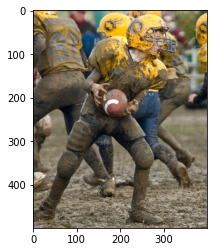

Sample 2
	 Captions 
a girl in a pink dress plays with a hula hoop
a girl wearing a pink dress swings a hula hoop around her neck
a little girl in a pick dress hula hoops with her neck outside
blond girl paying with a hula hoop
blond haired girl in pink dress with blue striped hula-hoop swinging around her neck


Predictions: a little girl in a pink dress is playing with a toy
 Bleu Score: 6.624396503292269e-155




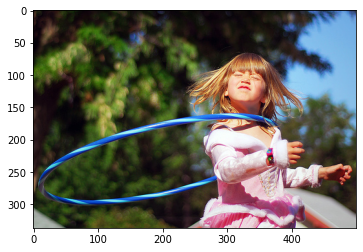

Sample 3
	 Captions 
a woman in a red costume to the left of a man and woman standing together
a woman wearing a red costume looks at two other people standing on a street
a young woman in a red sequined costume and feather stands on the sidewalk
the girl in the salmon colored bikini is standing next to two young people ; one is wearing a black outfit and the other is drinking pop
two young people are approached by a flamboyant young woman dressed in a red bikini and a red feathered headress


Predictions: a woman in a red shirt and a woman in a white shirt is walking down a street
 Bleu Score: 2.7968916142145135e-78




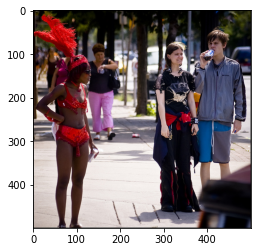

Sample 4
	 Captions 
a dog places his head on a man 's face
a dog snuggles with a man in sunglasses
a dog with a blue collar is licking a man who 's wearing large tinted sunglasses
a large brown dog with a blue collar is resting his chin on a man 's face
an orange dog is licking a man wearing red sunglasses


Predictions: a black dog is playing with a stick
 Bleu Score: 5.588971591971542e-155




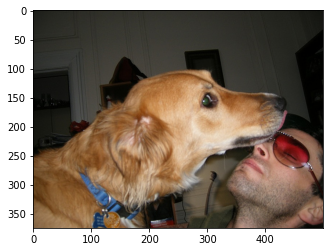

Sample 5
	 Captions 
a blonde woman is standing in the middle of a field of tall pink flowers
a blonde woman walks through shoulder-high pink tulips in front of a green field with a small house and trees in the distance
a woman sitting in a field of flowers
a woman standing among a bunch of pink flowers with a little shack in the back
the blonde woman is crouching in a field of pink tulips near a grassy field and trees


Predictions: a man in a blue shirt is standing in the grass
 Bleu Score: 3.991890743256307e-155




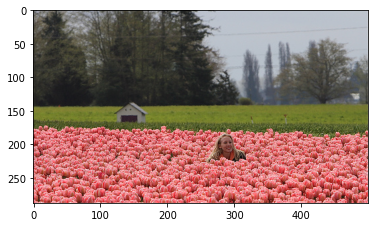

Sample 6
	 Captions 
a boy and three girls in blue school uniforms walk down a dirt-covered road
a group of children in blue uniforms walk to class
four children in uniforms stand in front of palm trees
four teens in school uniforms walk down a tropical road
group of school children in blue school uniforms


Predictions: a group of children are playing in the grass
 Bleu Score: 7.241926111174567e-155




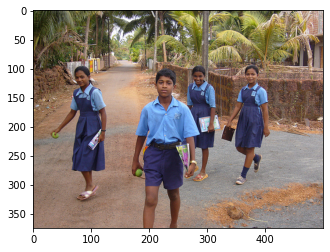

Sample 7
	 Captions 
a beautiful waterfall with two people walking on the road beside it
a beautiful waterfall flows down the side of a mossy rock wall
a waterfall cascades into a shallow pool
a waterfall splashes into a pool at the bottom of a steep grassy hill
two people travel down a path going though a woods with a giant waterfall


Predictions: a man is climbing a rock
 Bleu Score: 3.648956622645728e-232




/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


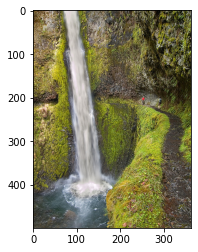

Sample 8
	 Captions 
dogs participating in a race
five dogs racing at night
greyhound are racing on a track and number eight is making a run for first
the dogs ran around the dirt racetrack
the greyhound dogs are racing along a dirt path with buildings nearby


Predictions: two dogs are running on a track
 Bleu Score: 3.775112189210336e-155




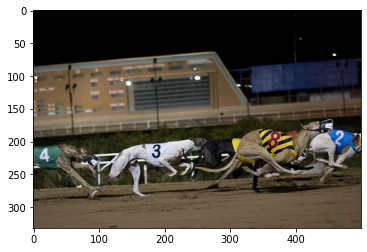

Sample 9
	 Captions 
a child in a graduation gown throws the cap in the air
a child who is celebrating their graduation in a field
a young child dressed in a graduation gown is throwing a graduation cap in the air
a young girl throws her graduation cap into the air
young girl in red graduation suit flings her hat upward into the field


Predictions: a young girl in a blue dress is standing in the grass
 Bleu Score: 3.1352625502397913e-78




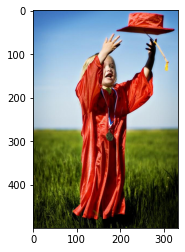

Sample 10
	 Captions 
a black dog is looking through the fence
a brown dog runs along a fence
a dark brown dog is running along a fence outside
a large black dog runs along a fence in the grass
the brown greyhound dog walks on green grass and looks through a fence


Predictions: a black and white dog runs through the grass
 Bleu Score: 1.0555182314382603e-231




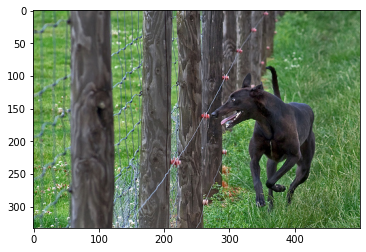

In [35]:
generate_examples(Data_handler,model,dist="dev")

In [37]:
cdf = Data_handler.caption_df
ddf = Data_handler.dist_df

In [39]:
new_df = cdf.iloc[0:5,:]

In [42]:
new_df

,Filename,Caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [43]:
ddf_g = ddf.groupby('Filename')


In [45]:
ddf_g.get_group(new_df.iloc[0,0])

,Filename,dist
1077,1000268201_693b08cb0e.jpg,train


In [46]:
new_cdf = pd.merge(new_df,ddf,how="inner",on="Filename")
new_cdf


,Filename,Caption,dist
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,train
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building,train
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse,train
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,train
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,train
